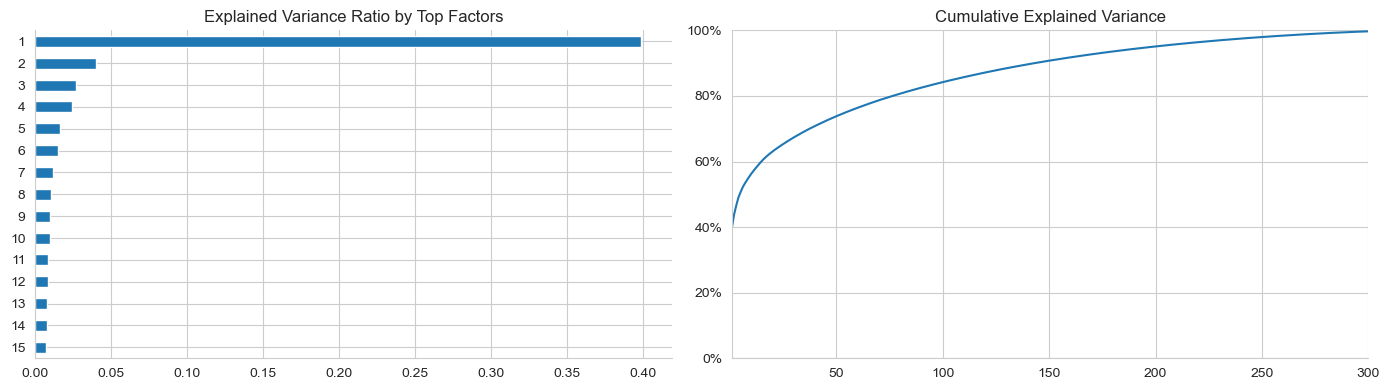

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
np.random.seed(42)

# Load data
with pd.HDFStore('./data/assets.h5') as store:
    stocks = store['us_equities/stocks'].marketcap.nlargest(500)
    prices = store['quandl/wiki/prices']

# Filter data for the selected stocks and date range
mask = (prices.index.get_level_values('ticker').isin(stocks.index)) & \
       (prices.index.get_level_values('date') >= '2010-01-01') & \
       (prices.index.get_level_values('date') <= '2018-12-31')
filtered_prices = prices.loc[mask, 'adj_close']

# Reshape data to wide format
returns = filtered_prices.unstack('ticker').pct_change()

# Winsorize & standardize returns
returns = returns.clip(lower=returns.quantile(q=.025), upper=returns.quantile(q=.975), axis=1)

# Impute missing values
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
daily_avg = returns.mean(1)
returns = returns.apply(lambda x: x.fillna(daily_avg))

# Fit PCA
cov = np.cov(returns, rowvar=False)
pca = PCA(n_components='mle')
pca.fit(returns)

# Visualize Explained Variance
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(pca.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title, ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1), ax=axes[1], title='Cumulative Explained Variance', xlim=(1, 300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.tight_layout()


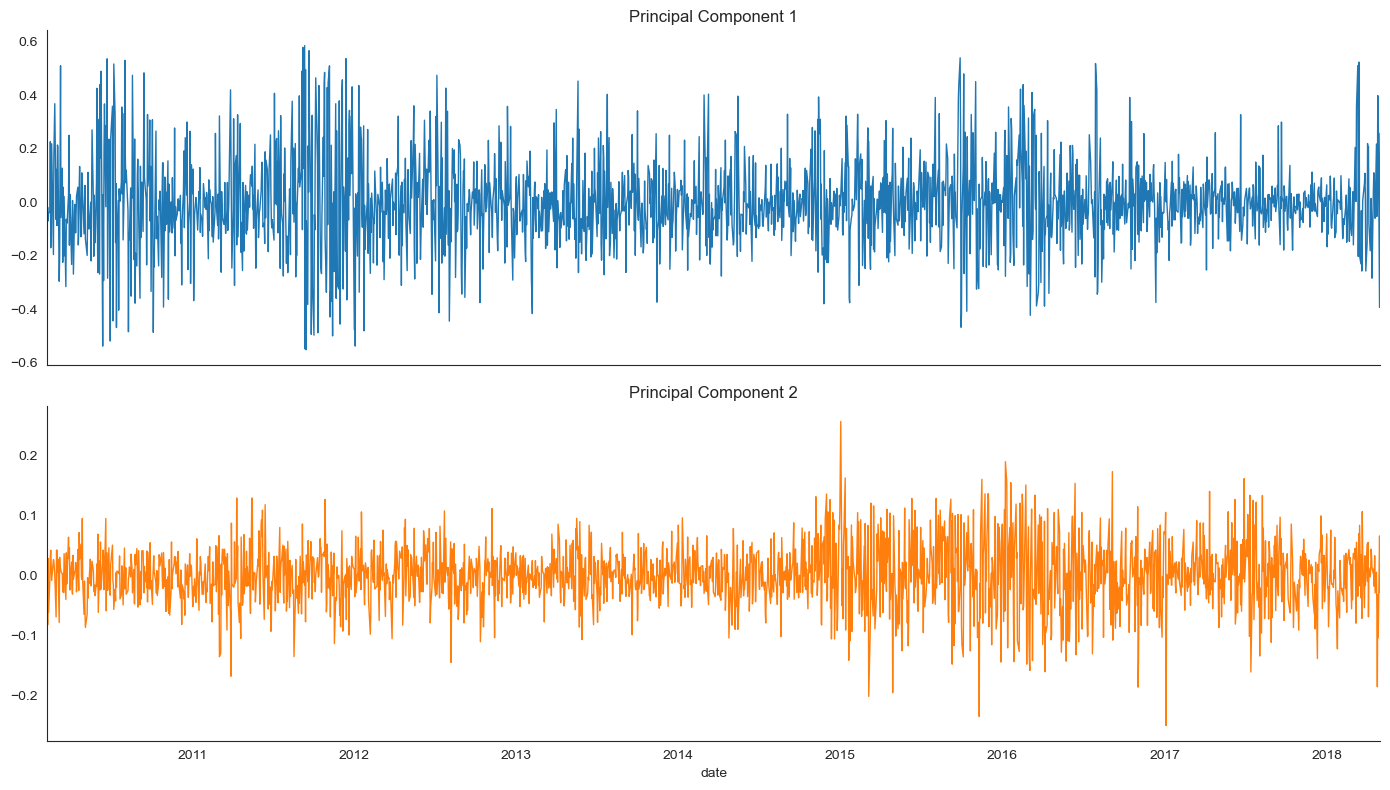

In [4]:
risk_factors = pd.DataFrame(pca.transform(returns)[:, :2], 
                            columns=['Principal Component 1', 'Principal Component 2'], 
                            index=returns.index)

# We can select the top two principal components to verify that they are indeed uncorrelated:

risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 2'])

# Moreover, we can plot the time series to highlight how each factor captures different volatility patterns.

with sns.axes_style('white'):
    risk_factors.plot(subplots=True,
                      figsize=(14, 8),
                      title=risk_factors.columns.tolist(),
                      legend=False,
                      rot=0,
                      lw=1,
                      xlim=(risk_factors.index.min(),
                            risk_factors.index.max()))

    sns.despine()
    plt.tight_layout()



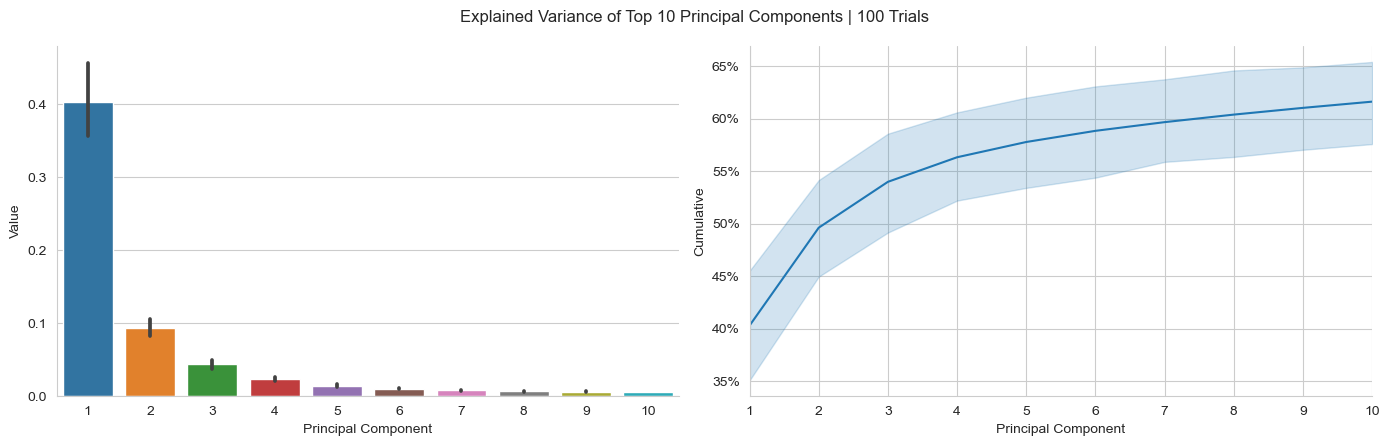

In [6]:
# Simulation for larger number of stocks

idx = pd.IndexSlice
with pd.HDFStore('./data/assets.h5') as store:
    returns = (store['quandl/wiki/prices']
              .loc[idx['2000': '2018', :], 'adj_close']
              .unstack('ticker')
              .pct_change())

pca = PCA()
n_trials, n_samples = 100, 500
explained = np.empty(shape=(n_trials, n_samples))
for trial in range(n_trials):
    returns_sample = returns.sample(n=n_samples)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[0] * .95), axis=1)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[1] * .95))
    daily_avg = returns_sample.mean(1)
    returns_sample = returns_sample.apply(lambda x: x.fillna(daily_avg))
    pca.fit(returns_sample)
    explained[trial, :len(pca.components_)] = pca.explained_variance_ratio_

explained = pd.DataFrame(explained, columns=list(range(1, explained.shape[1] + 1)))

fig, axes = plt.subplots(ncols=2, figsize=(14, 4.5))
pc10 = explained.iloc[:, :10].stack().reset_index()
pc10.columns = ['Trial', 'Principal Component', 'Value']

pc10['Cumulative'] = pc10.groupby('Trial').Value.transform(np.cumsum)
sns.barplot(x='Principal Component', y='Value', data=pc10, ax=axes[0])
sns.lineplot(x='Principal Component', y='Cumulative', data=pc10, ax=axes[1])
axes[1].set_xlim(1, 10)
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
fig.suptitle('Explained Variance of Top 10 Principal Components | 100 Trials')
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.90)

